In [1]:
# notebooks/04_portfolio_optimization.ipynb
# Task 4: Portfolio Optimization using forecasted TSLA return + historical BND & SPY

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# PyPortfolioOpt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting

In [3]:
import os, sys

# Go to project root (adjust path if needed)
os.chdir("..")  

# Add src folder to Python path
sys.path.append(os.path.abspath("src"))

In [4]:
# Parameters
DATA_PATH = "data/adj_close_prices.csv"
RESULTS_DIR = "results/task3"
TSLA_FORECAST_FILE = os.path.join(RESULTS_DIR, "arima_future_forecast.csv")   # change to chosen model file
FORECAST_HORIZON_DAYS = 252  # use 252 trading days ~ 1 year; adapt if forecast shorter
RISK_FREE_RATE = 0.0  # adjust if you want a realistic T-bill rate

# Create results dir for task4
SAVE_DIR = "results/task4"
os.makedirs(SAVE_DIR, exist_ok=True)

In [5]:
# 1. Load historical prices and compute daily returns
df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date")
prices = df[["TSLA", "BND", "SPY"]].asfreq("B").ffill()  # business day freq and forward-fill

# compute daily returns
daily_returns = prices.pct_change().dropna()

In [6]:
# 2. Compute historical annualized expected returns for BND and SPY
mu_hist = expected_returns.mean_historical_return(prices)  # annualized by PyPortfolioOpt
# mu_hist is a Series indexed by tickers
print("Historical annualized returns (annual):")
print(mu_hist)

Historical annualized returns (annual):
TSLA    0.317548
BND     0.017580
SPY     0.131402
dtype: float64


In [7]:
# 3. Get TSLA expected return from forecast
# Preferred: read forecast CSV produced in Task3 (forecasted prices)
# File expected with columns: ['forecast','ci_lower','ci_upper'] or similar
if os.path.exists(TSLA_FORECAST_FILE):
    tsla_forecast_df = pd.read_csv(TSLA_FORECAST_FILE, index_col=0, parse_dates=True)
    # some forecast files have 'forecast' column; if not, try first column
    if "forecast" in tsla_forecast_df.columns:
        forecast_series = tsla_forecast_df["forecast"]
    else:
        forecast_series = tsla_forecast_df.iloc[:, 0]
    # Derive expected annual return from forecast horizon:
    # Use last forecast point vs last historical price -> annualize
    last_hist_price = prices["TSLA"].dropna().iloc[-1]
    # If forecast index contains dates, we can compute horizon in days:
    try:
        days_horizon = (forecast_series.index[-1] - forecast_series.index[0]).days + 1
    except Exception:
        days_horizon = len(forecast_series)
    # Use CAGR formula from last_hist_price to mean(forecast) or last forecast value
    # Option A: use last forecast value
    last_forecast_price = forecast_series.iloc[-1]
    years = days_horizon / 365.25 if days_horizon > 0 else 1.0
    tsla_expected_annual_return = (last_forecast_price / last_hist_price) ** (1.0 / years) - 1.0
    print(f"TSLA forecast-based annual expected return (from last forecast point): {tsla_expected_annual_return:.4%}")
else:
    # Fallback: use historical mean
    print(f"Forecast file not found at {TSLA_FORECAST_FILE}; using historical returns for TSLA instead.")
    tsla_expected_annual_return = mu_hist["TSLA"]

TSLA forecast-based annual expected return (from last forecast point): -22.6392%


In [12]:
# 4. Build expected returns vector for optimization
mu = mu_hist.copy()        # start from historical for all
mu["TSLA"] = tsla_expected_annual_return  # replace TSLA with forecast-based view
print("\nFinal expected returns used for optimization:")
print(mu)


Final expected returns used for optimization:
TSLA   -0.226392
BND     0.017580
SPY     0.131402
dtype: float64


In [8]:
# 5. Covariance matrix (annualized) from historical daily returns
S = risk_models.sample_cov(prices)  # PyPortfolioOpt returns annualized covariance by default (uses 252)
print("\nAnnualized covariance matrix:")
print(S)


Annualized covariance matrix:
          TSLA       BND       SPY
TSLA  0.337568  0.001794  0.051026
BND   0.001794  0.002906  0.001109
SPY   0.051026  0.001109  0.032060


In [13]:
# 6. Efficient Frontier, Max Sharpe and Min Volatility
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))  # no shorting: bounds [0,1]
raw_weights_sharpe = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
w_sharpe = ef.clean_weights()
ret_sharpe, vol_sharpe, sharpe_sharpe = ef.portfolio_performance(verbose=False, risk_free_rate=RISK_FREE_RATE)

# Recompute for min volatility (a new EfficientFrontier instance recommended)
ef_min = EfficientFrontier(mu, S, weight_bounds=(0,1))
raw_weights_min = ef_min.min_volatility()
w_min = ef_min.clean_weights()
ret_min, vol_min, sharpe_min = ef_min.portfolio_performance(verbose=False, risk_free_rate=RISK_FREE_RATE)

print("\nMax Sharpe Portfolio Weights:")
print(w_sharpe)
print(f"Expected annual return: {ret_sharpe:.2%}, Volatility: {vol_sharpe:.2%}, Sharpe: {sharpe_sharpe:.2f}")

print("\nMin Volatility Portfolio Weights:")
print(w_min)
print(f"Expected annual return: {ret_min:.2%}, Volatility: {vol_min:.2%}, Sharpe: {sharpe_min:.2f}")


Max Sharpe Portfolio Weights:
OrderedDict([('TSLA', 0.0), ('BND', 0.53561), ('SPY', 0.46439)])
Expected annual return: 7.04%, Volatility: 9.11%, Sharpe: 0.77

Min Volatility Portfolio Weights:
OrderedDict([('TSLA', 0.0), ('BND', 0.94512), ('SPY', 0.05488)])
Expected annual return: 2.38%, Volatility: 5.30%, Sharpe: 0.45


C:\Users\Admin\AppData\Local\Temp\ipykernel_13340\293363833.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (asset_annual_vols[i], asset_annual_returns[i]), xytext=(6,0), textcoords='offset points')


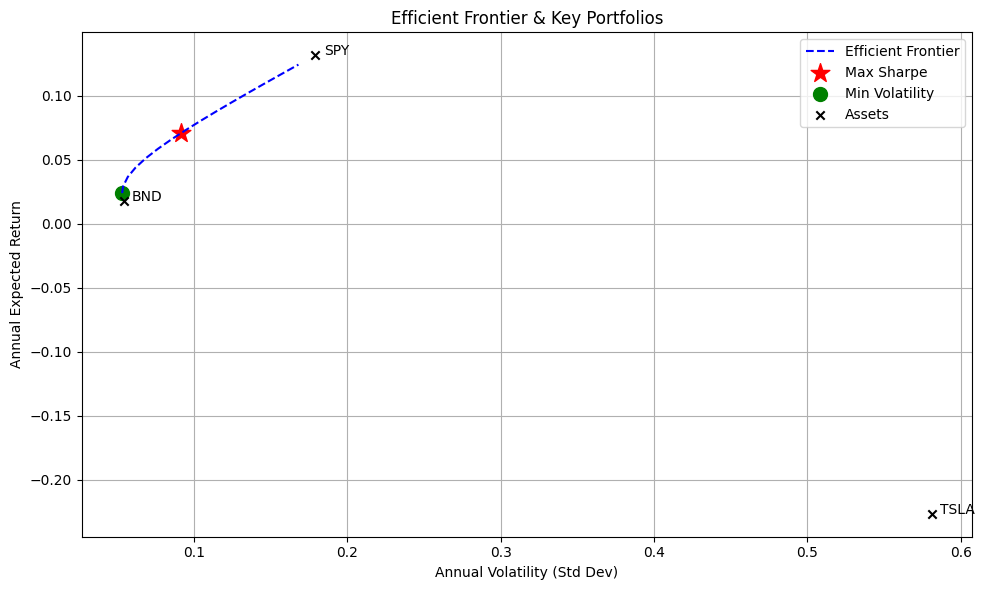

In [14]:
# 7. Generate Efficient Frontier points (for plotting)
# We'll sample target returns and minimize volatility for each target to build frontier
n_points = 50
target_returns = np.linspace(mu.min(), mu.max(), n_points)

ef_plot_returns = []
ef_plot_vols = []
from pypfopt import EfficientFrontier
for tr in target_returns:
    ef_tmp = EfficientFrontier(mu, S, weight_bounds=(0,1))
    try:
        w = ef_tmp.efficient_return(target_return=tr)
        perf = ef_tmp.portfolio_performance(verbose=False, risk_free_rate=RISK_FREE_RATE)
        ef_plot_returns.append(perf[0])  # annual return
        ef_plot_vols.append(perf[1])     # annual volatility
    except Exception:
        # skip unattainable targets
        pass

# 8. Plot Efficient Frontier and mark portfolios
plt.figure(figsize=(10,6))
plt.plot(ef_plot_vols, ef_plot_returns, 'b--', label="Efficient Frontier")
plt.scatter(vol_sharpe, ret_sharpe, c='red', marker='*', s=200, label="Max Sharpe")
plt.scatter(vol_min, ret_min, c='green', marker='o', s=100, label="Min Volatility")

# Plot individual assets
asset_annual_returns = mu
asset_annual_vols = np.sqrt(np.diag(S))
plt.scatter(asset_annual_vols, asset_annual_returns, c='black', marker='x', label="Assets")
for i, txt in enumerate(mu.index):
    plt.annotate(txt, (asset_annual_vols[i], asset_annual_returns[i]), xytext=(6,0), textcoords='offset points')

plt.xlabel("Annual Volatility (Std Dev)")
plt.ylabel("Annual Expected Return")
plt.title("Efficient Frontier & Key Portfolios")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "efficient_frontier.png"))
plt.show()

In [15]:
# 9. Save recommended portfolios and summary
summary = {
    "max_sharpe_weights": w_sharpe,
    "max_sharpe_return": ret_sharpe,
    "max_sharpe_vol": vol_sharpe,
    "max_sharpe_sharpe": sharpe_sharpe,
    "min_vol_weights": w_min,
    "min_vol_return": ret_min,
    "min_vol_vol": vol_min,
    "min_vol_sharpe": sharpe_min,
    "expected_returns_used": mu.to_dict()
}
pd.to_pickle(summary, os.path.join(SAVE_DIR, "portfolio_summary.pkl"))

# Also write a human-readable CSV for weights
pd.DataFrame([w_sharpe, w_min], index=["max_sharpe","min_vol"]).T.to_csv(os.path.join(SAVE_DIR, "recommended_weights.csv"))

print("\nSaved portfolio summary and weights to", SAVE_DIR)


Saved portfolio summary and weights to results/task4


In [16]:
# 10. Recommendation 
recommendation = f"""
Recommended Portfolio Recommendation (based on forecasted TSLA expected return and historical BND/SPY):

Max Sharpe (Tangency) Portfolio:
 - Weights: {w_sharpe}
 - Expected annual return: {ret_sharpe:.2%}
 - Expected annual volatility: {vol_sharpe:.2%}
 - Sharpe Ratio: {sharpe_sharpe:.2f}

Minimum Volatility Portfolio:
 - Weights: {w_min}
 - Expected annual return: {ret_min:.2%}
 - Expected annual volatility: {vol_min:.2%}
 - Sharpe Ratio: {sharpe_min:.2f}

Recommendation rationale:
 - If the client prioritizes risk-adjusted returns, choose Max Sharpe portfolio.
 - If the client prioritizes capital preservation, choose Min Volatility portfolio.
 - Consider transaction costs, tax implications and rebalancing frequency before implementation.
"""
print(recommendation)

# Save recommendation text
with open(os.path.join(SAVE_DIR, "recommendation.txt"), "w") as f:
    f.write(recommendation)


Recommended Portfolio Recommendation (based on forecasted TSLA expected return and historical BND/SPY):

Max Sharpe (Tangency) Portfolio:
 - Weights: OrderedDict([('TSLA', 0.0), ('BND', 0.53561), ('SPY', 0.46439)])
 - Expected annual return: 7.04%
 - Expected annual volatility: 9.11%
 - Sharpe Ratio: 0.77

Minimum Volatility Portfolio:
 - Weights: OrderedDict([('TSLA', 0.0), ('BND', 0.94512), ('SPY', 0.05488)])
 - Expected annual return: 2.38%
 - Expected annual volatility: 5.30%
 - Sharpe Ratio: 0.45

Recommendation rationale:
 - If the client prioritizes risk-adjusted returns, choose Max Sharpe portfolio.
 - If the client prioritizes capital preservation, choose Min Volatility portfolio.
 - Consider transaction costs, tax implications and rebalancing frequency before implementation.

